In [ ]:
!pip install sklearn_crfsuite
!pip install eli5

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*- 

#source code: https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/


##preparing dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


data = open("shuffled_train", "r").readlines()
data = [t[:-1] for t in data]

data_text = [t.split("\t")[0].split(' ')[1:-1] for t in data]  #.split(' ')[1:-1]
data_tag = [t.split("\t")[1].split(' ')[:-1] for t in data]  


# convert an empty 2D list into an empty 1D list
flatten = lambda l: [item for sublist in l for item in sublist]
unique_words = list(set(flatten(data_text)))
n_words = len(unique_words)


num_words = {}
for w in flatten(data_text):
    if w not in num_words:
        num_words[w] = 1
    else:
        num_words[w] +=1

        
        
#----

data_train = open("atis-2.train.w-intent.iob", "r").readlines()
data_train = [t[:-1] for t in data_train]

data_text_train = [t.split("\t")[0].split(' ')[1:-1] for t in data_train]  
data_tag_train = [t.split("\t")[1].split(' ')[:-1] for t in data_train]  

#---
data_test = open("atis-2.dev.w-intent.iob", "r").readlines()
data_test = [t[:-1] for t in data_test]

data_text_test = [t.split("\t")[0].split(' ')[1:-1] for t in data_test]  
data_tag_test = [t.split("\t")[1].split(' ')[:-1] for t in data_test] 






In [ ]:
sentences_train = []
for i in range(0, len(data_text_train)):
	text = data_text_train[i]
	tag = data_tag_train[i]
	l = list(zip(text,tag))
	sentences_train.append(l)
print(sentences_train[0])

sentences_test = []
for i in range(0, len(data_text_test)):
	text = data_text_test[i]
	tag = data_tag_test[i]
	l = list(zip(text,tag))
	sentences_test.append(l)

print(sentences_test[0])




In [ ]:
def word2features(sent, i, num_words):
    word = sent[i][0]
    # tag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word,
        # 'word[-3:]': word[-3:],
        # 'word[-2:]': word[-2:],
        # 'word.isupper()': word.isupper(),
        # 'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        # 'tag': tag,
        # 'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        # tag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1,
        #     '-1:word.istitle()': word1.istitle(),
        #     '-1:word.isupper()': word1.isupper(),
            '-1:word.isdigit()': word1.isdigit(),
            # '-1:tag': tag1,
            # '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True 

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        # tag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1,
        #     '+1:word.istitle()': word1.istitle(),
        #     '+1:word.isupper()': word1.isupper(),
            '+1:word.isdigit()': word1.isdigit(),
            # '+1:tag': tag1,
        #     '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True 
    
    return features


def sent2features(sent, num_words):
    return [word2features(sent, i, num_words) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

X_train = [sent2features(s, num_words) for s in sentences_train]
X_test = [sent2features(s, num_words) for s in sentences_test]
y_train = [sent2labels(s) for s in sentences_train]
y_test = [sent2labels(s) for s in sentences_test]
# print(X_train[0][0])


In [ ]:
## crf model
from sklearn_crfsuite import CRF

crf = CRF(algorithm='lbfgs',
          c1=5,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report

pred = cross_val_predict(estimator=crf, X=X_train, y=y_train, cv=5) ###--------------------

report = flat_classification_report(y_pred=pred, y_true=y_train)
print(report)



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

   B-bank_amount       0.00      0.00      0.00        24
        B-credit       0.00      0.00      0.00        20
    B-dec_amount       0.00      0.00      0.00        11
          B-dorm       0.71      0.45      0.55       272
         B-email       0.38      0.17      0.23        84
       B-faculty       0.75      0.56      0.64       241
         B-field       0.79      0.37      0.51       199
    B-food_price       0.00      0.00      0.00        16
         B-grade       0.93      0.88      0.91       356
    B-inc_amount       0.33      0.06      0.10        18
          B-meal       0.84      0.80      0.82       242
          B-name       0.86      0.42      0.56       841
 B-national_code       1.00      0.94      0.97       101
          B-pass       0.00      0.00      0.00         9
B-personnel_code       1.00      0.82      0.90        34
         B-phone       0.84      0.89      0.86       886
          B-s

In [ ]:
crf.fit(X_train, y_train)

import eli5
eli5.show_weights(crf, top=20)
print(eli5.format_as_text(eli5.explain_weights(crf, top=400)))

f = open("res_crf_20_train.txt", "w")
f.write(eli5.format_as_text(eli5.explain_weights(crf, top=20)))
f.close()

In [ ]:
y_pred = []
for item in X_test:
  pred = crf.predict_single(item)
  y_pred.append(pred)

print((y_pred[39]))
print((y_test[39]))



report = flat_classification_report(y_pred=y_pred, y_true=y_test)
print(report)



['O', 'O', 'O', 'O', 'O', 'B-grade', 'B-field', 'I-field', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'B-grade', 'B-faculty', 'I-faculty', 'O', 'O', 'O', 'O', 'O', 'O', 'B-self', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
                  precision    recall  f1-score   support

   B-bank_amount       0.00      0.00      0.00         4
        B-credit       0.00      0.00      0.00         1
    B-dec_amount       0.00      0.00      0.00         1
          B-dorm       0.74      0.60      0.66        75
         B-email       0.50      0.25      0.33        20
       B-faculty       0.79      0.56      0.65        54
         B-field       0.87      0.46      0.60        59
    B-food_price       0.00      0.00      0.00         1
         B-grade       0.96      0.88      0.91        98
    B-inc_amount       0.00      0.00      0.00         3
          B-meal       0.82      0.84      0.83        75
          B-name       0.8

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print(y_pred[3])

['O', 'O', 'B-meal', 'O', 'B-meal', 'O', 'O', 'O', 'O', 'O', 'B-student_num', 'B-phone']


In [ ]:
y_predd = []
y_testt = []
print(len(y_pred))
print(len(y_test))
for line in y_pred:
  for item in line:
    y_predd.append(item)
for line in y_test:
  for item in line:
    y_testt.append(item)

532
532


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_true=y_testt, y_pred=y_predd, average='micro')

0.9592988710635769

[[18097     0     0 ...     0     0     0]
 [    4     0     0 ...     0     0     0]
 [    3     0     0 ...     0     0     0]
 ...
 [    1     0     0 ...     0     0     0]
 [    1     0     0 ...     0     0     0]
 [    3     0     0 ...     0     0     0]]


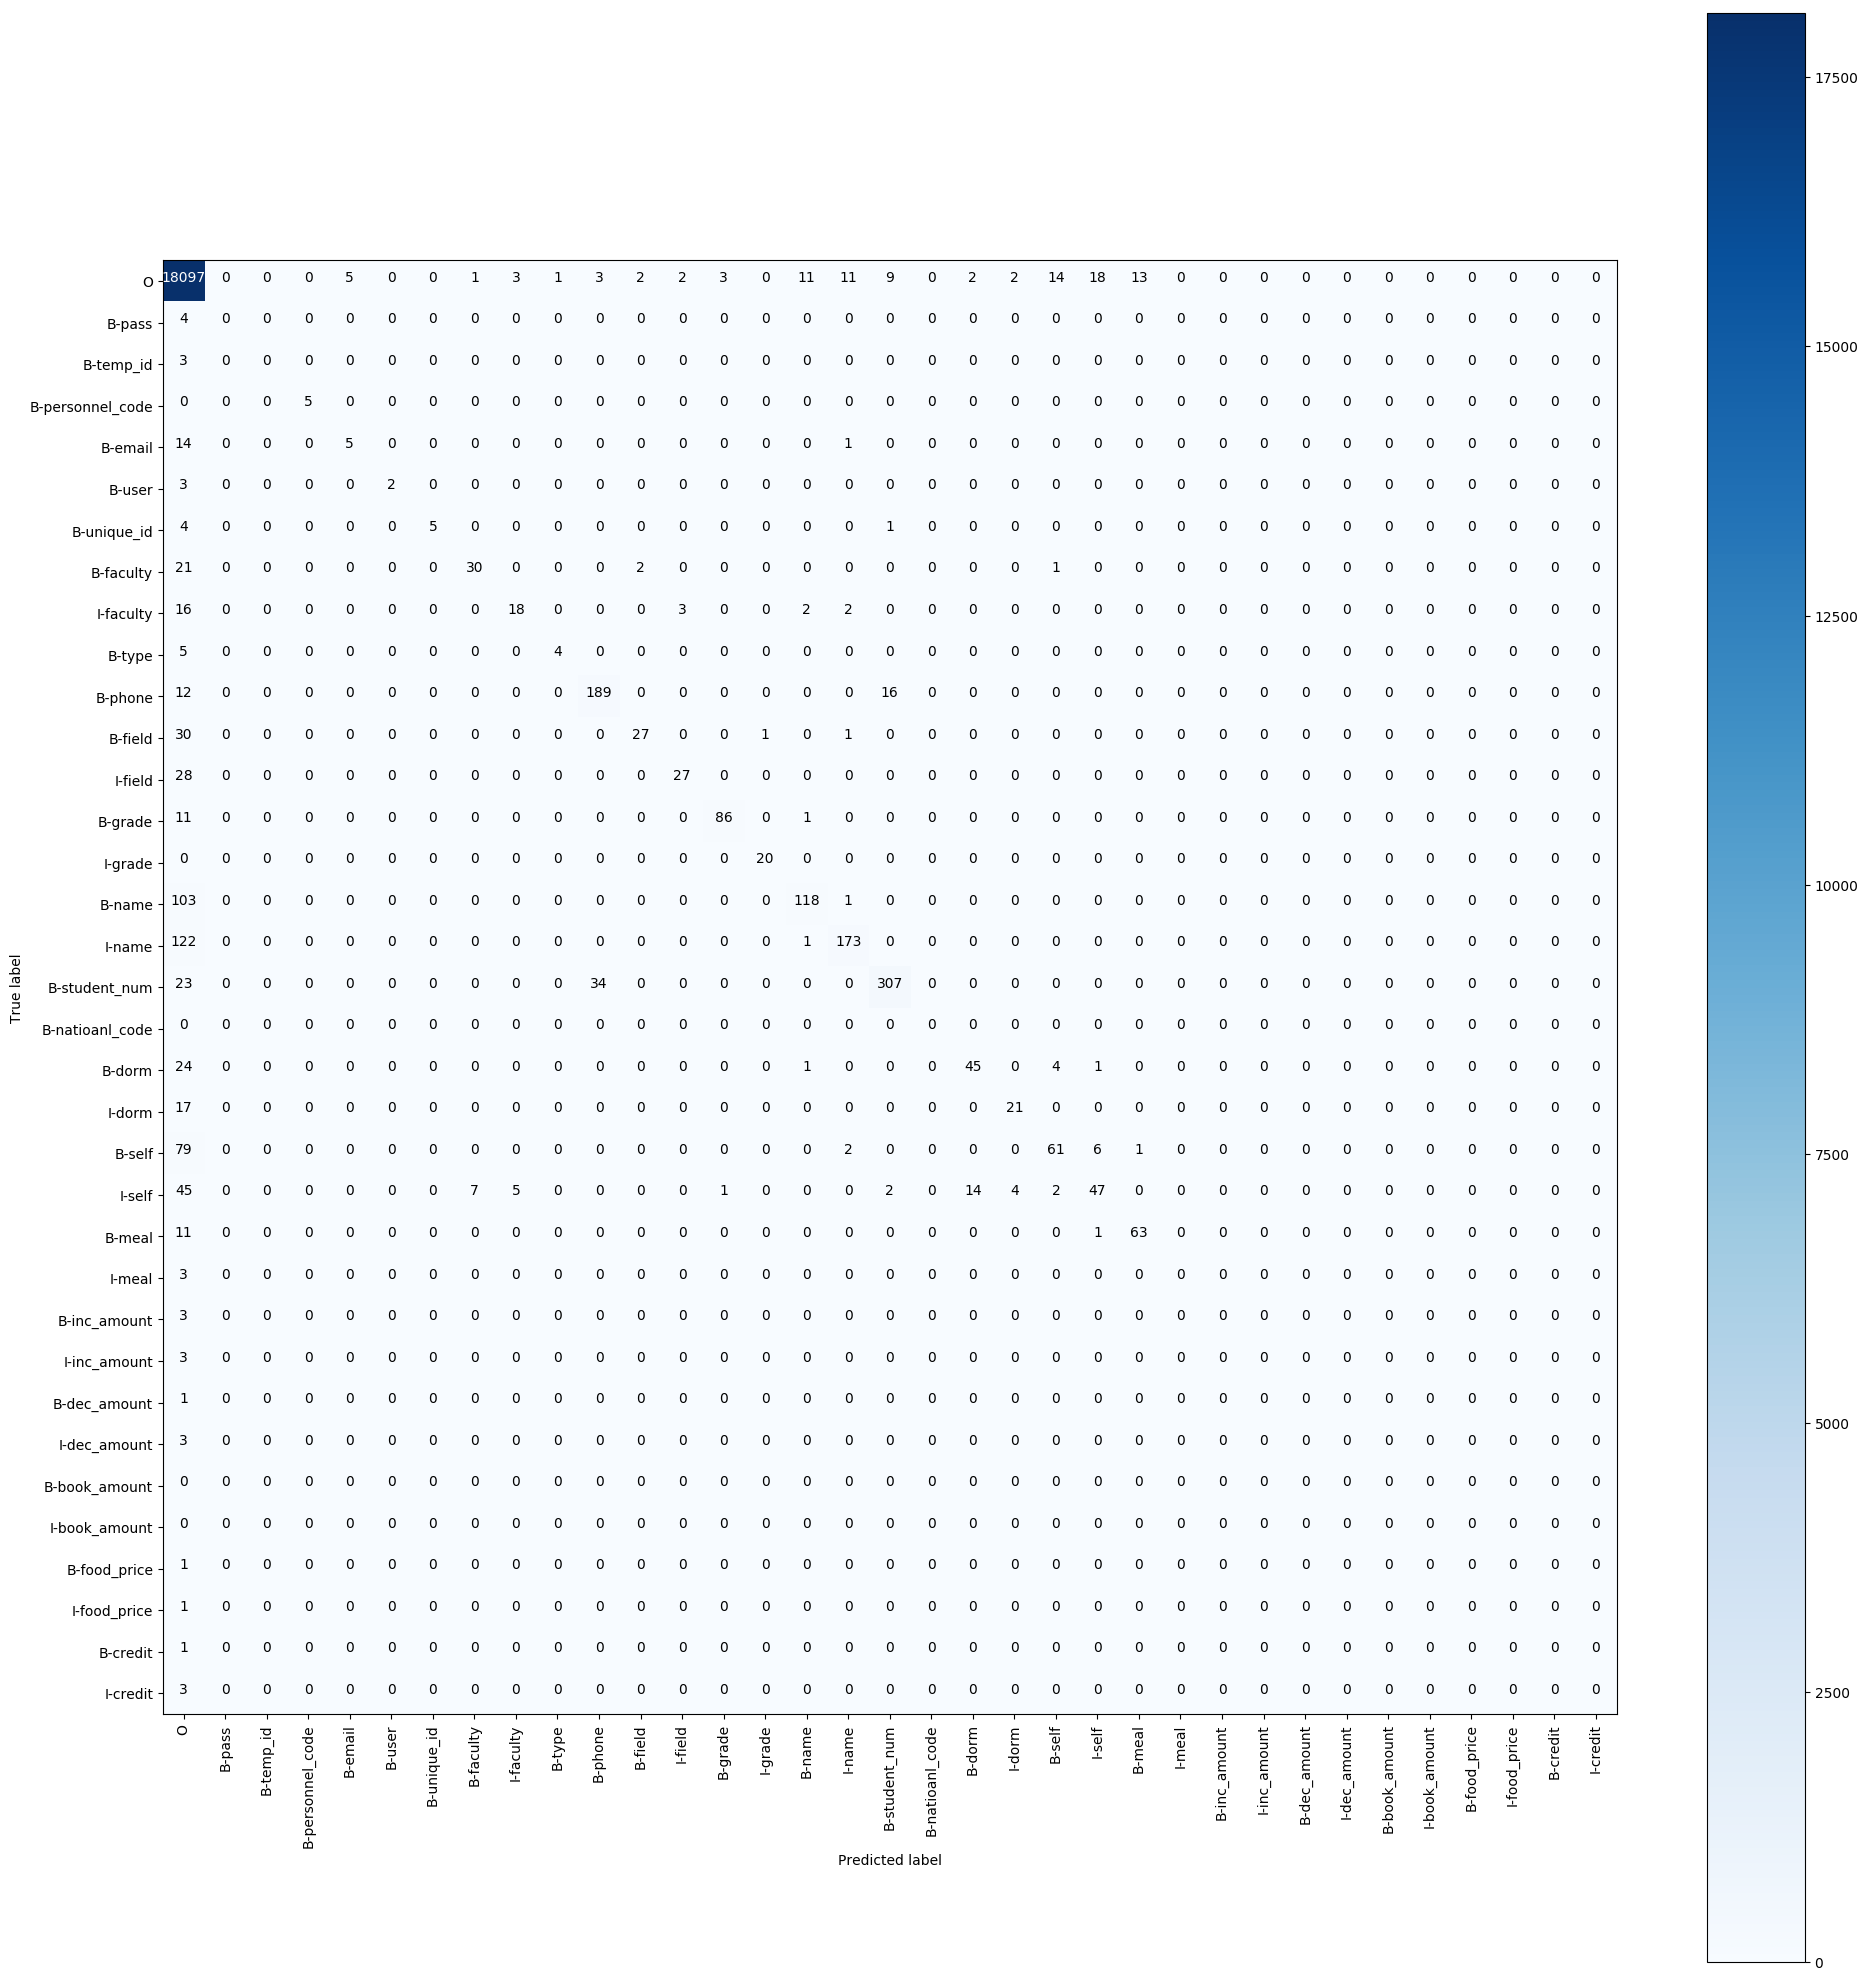

In [ ]:
#confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    

    print(cm)
    plt.ion()
    plt.figure(num=None, figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
labels = ['O','B-pass','B-temp_id','B-personnel_code','B-email','B-user','B-unique_id','B-faculty', 'I-faculty', 'B-type', 'B-phone', 'B-field', 'I-field', 'B-grade', 'I-grade', 'B-name', 'I-name', 'B-student_num', 'B-natioanl_code', 'B-dorm', 'I-dorm', 'B-self', 'I-self', 'B-meal', 'I-meal', 'B-inc_amount', 'I-inc_amount', 'B-dec_amount', 'I-dec_amount', 'B-book_amount', 'I-book_amount', 'B-food_price', 'I-food_price', 'B-credit', 'I-credit']    



cnf_matrix = confusion_matrix(y_testt, y_predd,labels=labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')
